# Analysis of Physical Oceanographic Data - SIO 221A
### Python version of [Sarah Gille's](http://pordlabs.ucsd.edu/sgille/sioc221a/index.html) notes by:
#### Bia Villas Bôas (avillasboas@ucsd.edu) & Gui Castelão (castelao@ucsd.edu)

## Lecture 7

*Reading:  Bendat and Piersol, Ch. 4.2.2, 5.2.2, 8.5.4*

#### Recap

Last time we looked at Parseval's theorem as a starting point for computing
spectra, and we started computing a test spectrum.   So far, our
basic recipe for computing spectra is simple:

1. Compute fft(data)

2. Compute squared amplitude for half of fft. Multiply by factor of 2

3. Normalize by N = length of record

4. Plot with a log-log axis

But we only considered some of the issues. Now we need to consider some real world issues.
How do we cut down on all the wiggles, so that our spectra look like
the ones in papers? What are uncertainties?  What happens when there's a background trend?
What about all of those frequencies that we don't resolve?

*Computing spectra (continued.)*

6. We can plot what we have.  Typically we use a loglog axis
(or at least semilogy).  We'll need to compute our frequencies
thoughtfully.  So for example if we have measurements every 361
seconds, then we might want to convert to cycles per hour by scaling
the frequency appropriately.

`scale = 1/361 * 3600`, to convert from 1 cycle per 361 seconds to cycles per hour

`frequency = np.arange(N/2)/N * scale`, for N even

`frequency = np.arange((N+1)/2)/N * scale`, for N odd

8. Now, we have a problem in that our results are way too noisy.  We'll have a hard time distinguishing signal from peak.  So clearly we're going to need more realizations. To do this, one common practice is chop our data into multiple segments. As a first step, we can just cut the data into $M$ segments of $N/M$ points each. For example, here's a brute strenght approach:

`N = len(data)`

`M = 6`

`p = N/M`

Where, M is the number of segments and p is the length of each segment.

`data_segments = data.reshape(M, p)`

Now, `data_segments` will have M segments (rows) of length p (columns). So, for each segment (row) we want to compute the fft accross all columns.

`fft_segments = np.fft.fft(data_segments, axis=1)`

`amp_segments = abs(fft_segments[:,:p//2]/p)**2`

`amp_segments[:,1:] = 2 * amp_segments[:,1:]`

`freq_segments = np.arange(p//2)/p * scale`

Here you can debate whether you should be plotting the sum (to
conserve energy) or the average (to represent a mean spectrum for
a data set of length $p$.  In most cases you'll want the average.

#### Python demo

Let's test this on some fake data. We will make somthing oscilatory and very noisy, with a frequency of on cycle per day and a sampling rate of one measurement per hour.

In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

In [2]:
T = 24 # period of the diurnal cycle in hours
t = np.arange(0, 20*24, 1) # sampling time is every hour for 20 days
data = cos(2*pi*t/T) + 1.5*np.random.randn(len(t)) #generate noisy fake data

Let's look at the time series

Text(0.5, 0, 'Time [hours]')

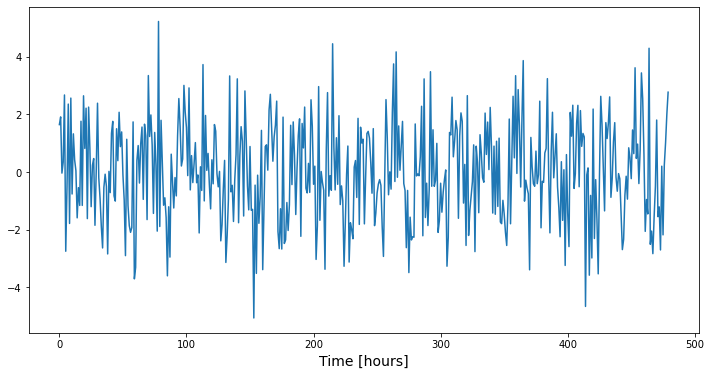

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(t, data)
plt.xlabel('Time [hours]', fontsize=14)

Now, let's check the eveness of N

In [4]:
N = len(data) #length of the timeseries
if N%2==0:
    print('N is even')
else:
    print('N is odd')

N is even


In [5]:
scale = 1*24 # scale the frequency to be in cycles per day
freq = np.arange(N//2)/N * scale
fft_data = np.fft.fft(data)
amp = abs(fft_data[:N//2]/N)**2 # we only get the positive frequencies (half the energy)
amp[1:] = 2*amp[1:] # and now we multiply by two to put the energy back (not considering the mean)

Now, we can check if Parseval's work

In [6]:
print('Fourier space', amp.sum())
print('Physical space', data.var())

Fourier space 2.9067241423028056
Physical space 2.906399747790237


And we can plot it in a log-log plot:

Text(0, 0.5, 'amplitude squared')

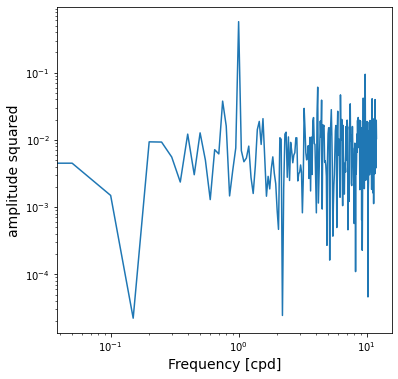

In [7]:
plt.figure(figsize=(6,6))
plt.loglog(freq, amp)
plt.xlabel('Frequency [cpd]', fontsize=14)
plt.ylabel('amplitude squared', fontsize=14)

We see that it is hard to distinguish the diurnal peak from the noise. Now lets create five segments of four days (96 hours).

In [8]:
M = 5
p = N//M
print('length of the data =', N, 'Number of segments =', M,'segment length =',p)

length of the data = 480 Number of segments = 5 segment length = 96


In [9]:
data_segments = data.reshape(M, p)
print(data_segments.shape)

(5, 96)


In [10]:
fft_segments = np.fft.fft(data_segments, axis=1)
print(fft_segments.shape)

(5, 96)


In [11]:
amp_segments = abs(fft_segments[:,:p//2]/p)**2
amp_segments[:,1:] = 2*amp_segments[:,1:]
freq_segments = np.arange(p//2)/p * scale

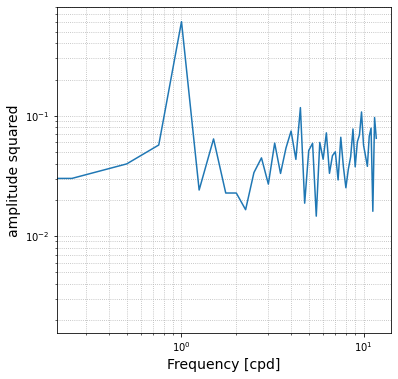

In [12]:
plt.figure(figsize=(6,6))
plt.loglog(freq_segments, amp_segments.mean(axis=0))
plt.xlabel('Frequency [cpd]', fontsize=14)
plt.ylabel('amplitude squared', fontsize=14)
plt.grid(which='both', ls='dotted')

#### Detrending

Now the critical question?  How many degrees of freedom does this record have?
Is this $M$ to represent $M$ segments?  Maybe you can think of it that way,
but by convention, we get one degree of freedom for the real part and
one for the imaginary part, so 2 per segment.  We'll need this to
compute error bars, but let's start by noting that our error bars
are not the same as the standard error of the mean.  We're computing the
sum of $M$ squared quantities, and that's going to depend on something
that looks like a $\chi^2$ distribution.

When we compute spectra from segments,
clearly there are tradeoffs:  if I have $N$ data points total, I can have lots
of segments with few points in each segment, or few segments with more points
per segment.  The Nyquist frequency will be the same whatever I choose, since
that's determined by the interval between observations.  But the low-frequency
limit will differ, as will the increment between frequencies (which is determined
by the lowest resolved frequency).  There's no rule for how to handle this,
and your decisions will depend whether you want small uncertainties or
high resolution in frequency space.

We will work with the weekly CO$_2$ records from [Mauna Loa](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).

In [59]:
import pandas as pd

In [60]:
df = pd.read_csv('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.csv', header=47)
df.head()

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07


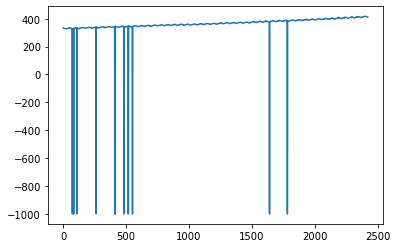

In [61]:
plt.plot(df.average)

Ok, so we see that the bad values are negative (more specifically -999). Let's replace them by NaNs

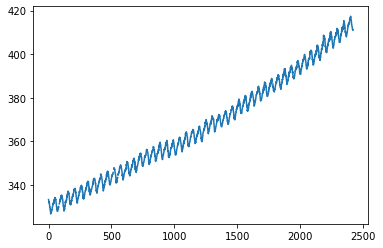

In [62]:
df.loc[df.average<0, 'average'] = np.nan
df['average'] = df['average']
plt.plot(df.average)

In [63]:
data = df['average'].values[:-20] # Getting an even number just to illustrate
print(len(data))

2400


In [64]:
N = len(data)
M = 10
p = N//M
data_segments = data.reshape(M, p)
print(data_segments.shape)

(10, 240)


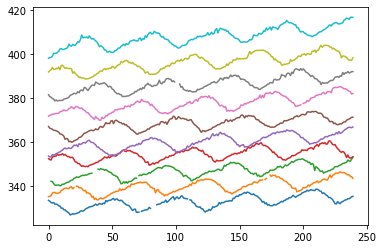

In [65]:
for i in range(10):
    plt.plot(data_segments[i])

But we can't FFT with NaNs, so let's remove the mean of each segment and then replace the NaNs by zeros.

In [66]:
segments_demean = []
for i in range(10):
    segments_demean.append(data_segments[i] - np.nanmean(data_segments[i]))
segments_demean = np.array(segments_demean)

In [70]:
# Check if the mean was removed
np.nanmean(segments_demean, axis=1)

array([ 1.40893944e-14,  2.69765378e-14,  6.31593543e-15,  7.34227494e-15,
       -4.73695157e-16, -1.68161781e-14,  3.99568802e-14,  4.98878950e-14,
       -2.98427949e-14, -1.72898732e-14])

In [105]:
# Now replace the NaNs by zero
segments_demean[np.isnan(segments_demean)] = 0

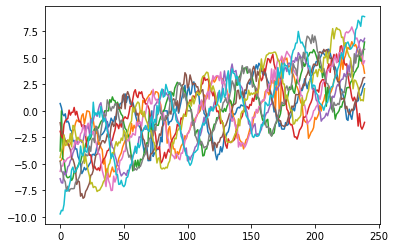

In [106]:
for i in range(10):
    plt.plot(segments_demean[i])

Now, we're ready to FFT

In [119]:
fft_segments = np.fft.fft(segments_demean, axis=1)
print(fft_segments.shape)

(10, 240)


In [120]:
amp_segments = abs(fft_segments[:,:p//2]/p)**2
amp_segments[:,1:] = 2*amp_segments[:,1:]

In [121]:
scale = 52.1429 # cycle per week to cycles per year
freq_segments = np.arange(p//2)/p * scale

(0.0001, 10.0)

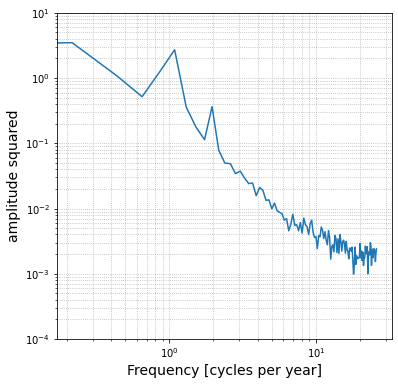

In [122]:
plt.figure(figsize=(6,6))
plt.loglog(freq_segments, amp_segments.mean(axis=0))
plt.xlabel('Frequency [cycles per year]', fontsize=14)
plt.ylabel('amplitude squared', fontsize=14)
plt.grid(which='both', ls='dotted')
plt.ylim([1e-4, 1e1])

The spectrum is pretty red, Let's they to detrend each segment.

In [113]:
from scipy import signal

In [123]:
data_dtrend = signal.detrend(segments_demean, axis=1, type='linear')
fft_segments = np.fft.fft(data_dtrend, axis=1)
amp_segments = abs(fft_segments[:,:p//2]/p)**2
amp_segments[:,1:] = 2*amp_segments[:,1:]

(0.0001, 10.0)

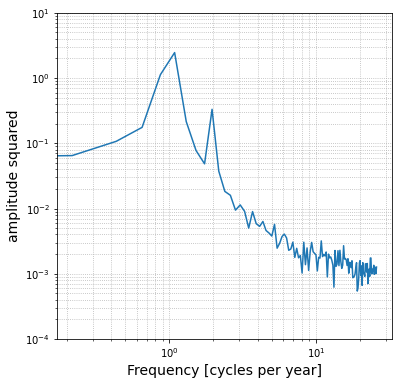

In [125]:
plt.figure(figsize=(6,6))
plt.loglog(freq_segments, amp_segments.mean(axis=0))
plt.xlabel('Frequency [cycles per year]', fontsize=14)
plt.ylabel('amplitude squared', fontsize=14)
plt.grid(which='both', ls='dotted')
plt.ylim([1e-4, 1e1])

### Windowing: A quick introduction

Often we also want to smooth out the edges.  The discrete Fourier transform  implicitly assumes
that our record repeats again and again, so any discontinuity between the beginning and end of
the record can create a step function.  To minimize that, we can multiply each segment by a
function that minimizes the impact of the edges.  (This sounds like it might grossly destroy our spectrum,
but we use something that's a bit Gaussian, so its Fourier transform is also fairly Gaussian,
and things come out reasonably.)  We'll talk more about this, but for now, let's just try
a Hanning window:

$$
w(t) = \cos^2\left(\frac{\pi t}{2T}\right) = \frac{1 + \cos(\pi t/T)}{2} = 0.5 + 0.5\cos(\pi t/T). \hspace{3cm} (1)
$$

This is defined to be centered around 0, for $|t|\le T$.
So we can multiply our full record by the Hanning window.  (Be sure to detrend first, so that
you aren't zeroing out the mean.)

#create a hanning window

`window = np.hanning(p)*np.ones([M,1])`

#multiply each detrended segment by the window and fft 

`fft_hanning = np.fft.fft(data_dtrend * window)`

In [134]:
window = np.hanning(p)*np.ones([M,1]) 
fft_hanning = np.fft.fft(data_dtrend*window)
amp_hanning = abs(fft_hanning[:,:p//2]/p)**2
amp_hanning[:,1:] = 2*amp_hanning[:,1:]

(0.0001, 10.0)

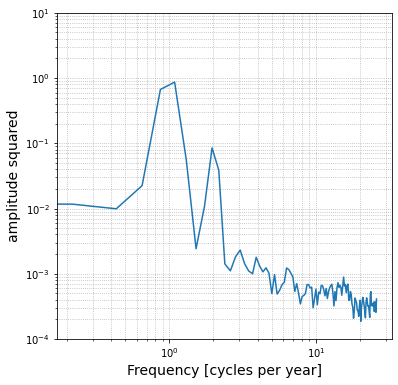

In [135]:
plt.figure(figsize=(6,6))
plt.loglog(freq_segments, amp_hanning.mean(axis=0))
plt.xlabel('Frequency [cycles per year]', fontsize=14)
plt.ylabel('amplitude squared', fontsize=14)
plt.grid(which='both', ls='dotted')
plt.ylim([1e-4, 1e1])

### Exercises

What are the Fourier transforms of the following functions:
$x(t)=1, x(t)=\cos(2\pi f t), x(t)=\sin(2\pi f t), x(t)=\exp(-t^2/2\sigma^2),
x(t)=t$?

In our examples, note that the Fourier transforms of single frequency sine and
cosine give a single peak.  (This uses the Kronecker delta, $\delta_{nm}$.)
The Gaussian ($x_f(t)$), has a transform of a Gaussian, though it's a bit distorted
in this finite-length log-log domain.  Formally if $x_f(t) = e^{-t^2/(2\sigma^2)}$,
then $X_f(f)=\sqrt{2\pi}\sigma e^{-2\pi^2 f^2 \sigma^2}$ or with coefficients $x_f(t)= \sqrt{\alpha/\pi} e^{-\alpha t^2}$ corresponds to $X_f(f)=e^{-\pi^2 f^2/(a)}$, which says in essence that the
Fourier transform of a Gaussian is still a Gaussian.  The normalization for this
is dependent on our exact notation for the Fourier transform.  And the linear
pattern should really be thought of as a repeating sawtooth.  It's Fourier
transform will is a dramatically red spectrum.  What does this mean for the
Fourier transform of any long-term trend?

{\bf Spectral Uncertainties}

The problem with all of the spectra that we've computed so far
(the amplitude of the Fourier Transform) is
that we have no way to evaluate the uncertainty. By eye we can see
that it's fairly noisy.  We know from computing means that the error of the
mean decreases as we average more quantities together.

How do we incorporate
more data into our spectra?  You might imagine that you could improve
your spectrum by extending the input time series from $N$ to $2N$ data points
for example.  Unfortunately, although adding data points will change your
spectrum, it won't reduce your noise or make the spectrum more precise at
any individual frequency.  Instead it will increase the number of frequencies
for which you obtain results from $N/2$ to $N$.

Error bars for
spectra rely on a principle similar to what we used when we
estimated the standard error of the mean.  Our uncertainties in our spectra
decrease as we average more spectra together.  The challenge is to figure
out how to obtain more spectra that can be averaged together.  Typically
what we do is to break our time series into segments, compute spectra
for each of the segments, and average these to get a mean spectrum.  Since
we're averaging squared quantities (the spectral amplitudes) the distribution
of the sum will follow a $\chi^2$ distribution.  And we'll use this to
estimate the uncertainties.
When we compute our estimate of the spectrum of our data, we'll compute
coefficients $a(f)$, and for $M$ segments, at frequency $f$,
the estimated spectrum will be

$$
\begin{equation}
\hat{E}(f) = \langle |a(f)|^2\rangle = \frac{1}{n}\sum_{i=1}^{n} |a(f)|^2 \hspace{3cm} (2)
\end{equation}
$$

(Since we actually had two degrees of freedom for each segment, this will give
us $\nu = 2n$ degrees of freedom.)

Now to estimate errors the whole argument stems from a notion that there is a true spectrum $E(f)$,
which we don't know, and our best estimate $\hat E(f)$, that we've
computed, but which might be noisy.  We could consider the difference
between $E$ and $\hat{E}$, but  this gets hairy quickly.  Besides we're
going to look at our results in log/log space anyway.  So let's look at the
ratio of the two.  Recall that $\ln(\hat{E}/E) = \ln(\hat{E})-\ln(E)$.
We can define a variable that represents this sum of squares normalized by
the true spectrum

$$
\begin{equation}
y = \nu \frac{\hat{E}_\nu(f)}{E(f)} \hspace{3cm} (3)
\end{equation}
$$

where $\hat{E}_\nu$ is our best estimate of the spectrum from real observations,
when we have $\nu$ degrees of freedom.  This variable should have a
$\chi^2$ distribution with $\nu$ degrees of freedom.
Thus we'll always consider the ratio
$\hat E(f)/E(f)$, where we use $\nu/2$ data segments.

So even though we don't know $E$, we know that the ratio of $\nu\hat{E}$ to $E$
($\nu\hat{E}/E$)
is a $\chi^2$ quantity.  The expectation value of this ratio is $\nu$, and
the standard deviation is $\langle y^2\rangle - \langle y\rangle^2 = 2\nu$ (see
Bendat and Piersol, section 4.2.2).
From that we can infer that with two
degrees of freedom, the standard deviation $\langle\hat{E}^2\rangle -
\langle\hat{E}\rangle^2 = 2/\nu E_0^2 = E_0^2$, which means that
the standard deviation is equal to the original value.  Clearly we need more
samples.

Now in reality, we don't care about the details of $\chi^2$ but rather the probability that
our estimate of the spectrum $\hat{E}$ is close to or far from the unknown
true spectrum $E$, so
we're going to look at the probability that  $\nu \hat E(f)/E(f)$
falls within a fixed range.  So we want to use the  $\chi^2$ distribution as
a probability distribution and ask about the probability that  $\hat E(f)/E(f)$ should be within $\pm$ some range of 1.
Formally, the probability that the estimated spectrum should be close
in value to the true spectrum is:

$$
\begin{equation}
P\left(\chi_{\nu,1-\alpha/2}^2 < \nu \frac{\hat E(f)}{E(f)} <
\chi_{\nu,\alpha/2}^2\right)  = 1-\alpha \hspace{3cm} (4)
\end{equation}
$$

so if we want to find a 95\% significance level, we set $\alpha$ to 0.05.
We'll want to know the value of $\chi^2$ that corresponds to a given
point on the cdf, so for this we use the inverse $\chi^2$ function (''chi2inv''
in Matlab).
So we can invert this relationship to provide the probability that the true value is
within a particular range of the observed value:

$$
\begin{equation}
P\left(\frac{\chi_{\nu,1-\alpha/2}^2}{\nu} < \frac{\hat E(f)}{E(f)} <
\frac{\chi_{\nu,\alpha/2}^2}{\nu}\right) = 1-\alpha \hspace{3cm} (5)
\end{equation}
$$

$$
\begin{equation}
P\left(\frac{\nu}{\chi_{\nu,1-\alpha/2}^2} > \frac{E(f)}{\hat E(f)} >
\frac{\nu}{\chi_{\nu,\alpha/2}^2}\right) = 1-\alpha \hspace{3cm} (6)
\end{equation}
$$

$$
\begin{equation}
P\left(\frac{\nu \hat{E}(f)}{\chi_{\nu,1-\alpha/2}^2} > E(f) >
\frac{\nu \hat{E}(f)}{\chi_{\nu,\alpha/2}^2}\right) = 1-\alpha \hspace{3cm} (7)
\end{equation}
$$

$$
\begin{equation}
P\left(\frac{\nu}{\chi_{\nu,\alpha/2}^2} < \frac{E(f)}{\hat E(f)} <
\frac{\nu}{\chi_{\nu,1-\alpha/2}^2}\right) = 1-\alpha \hspace{3cm} (8)
\end{equation}
$$

Whether you use $\chi^2$ or its reciprocal, the ratio between the high and low
error bars should be the same, and the ratio will be what matters.

This error formulation differs from the usual error bars that we're used
to seeing where we say for example that the true temperature should be
the measured temperature plus or minus an uncertainty:  $T = \hat T \pm
\delta_T$.   We can develop a similar expression for the true spectrum:
$E(f)$ is in the range between
$\nu \hat E(f)/\chi_{\nu,\alpha/2}^2$ and
$\nu \hat E(f)/\chi_{\nu,1-\alpha/2}^2$,
where $\nu$ is twice the number of segments.
This expression isn't very easy to interpret, since it varies
as a function of frequency, and the estimated value $\hat E(f)$ is
not  at the mid-point of the range.

Instead we'll keep in mind that we've computed the uncertainty for
the ratio $\hat E(f)/E(f)$, and the probabilities for this ratio
does not depend on frequency.  On a log plot, error bars defined
by the range between $\nu/\chi_{\nu,\alpha/2}^2$ and
$\nu/\chi_{\nu,1-\alpha/2}^2$ are the same size at all frequencies, so we can
easily compare spectral peaks at different frequencies.

Some statistics books include look-up tables for $\chi^2$, but we can compute
it directly in Matlab.  For $\nu=N/2$ data segments, the error limits are: